In [1]:
import os, glob
import pandas as pd
import geopandas as gpd
import numpy as np
import folium
from folium.plugins import HeatMap
import matplotlib.pyplot as plt
import seaborn as sns

Question: does superhost correlate with anything at all?

In [2]:
#parameters setup
local_folder='C:\\Users\\quynhvt5\\Documents\\airbnb\\'
listings_csvs=glob.glob(os.path.join(local_folder, '*_listings.csv'))
listings_columns=['id', 'host_is_superhost', 'latitude', 'longitude', 'review_scores_rating']
calendar_csvs=glob.glob(os.path.join(local_folder, '*_calendar.csv'))
calendar_columns=['listing_id', 'date', 'available', 'price']

In [3]:
#read in listings and cast to geopandas
listings_df=pd.concat([pd.read_csv(listings_csv, header=0, usecols=listings_columns) for listings_csv in listings_csvs], axis=0, ignore_index=True)
listings_gdf=gpd.GeoDataFrame(listings_df, geometry=gpd.points_from_xy(listings_df.longitude, listings_df.latitude))
listings_gdf.crs = {'init': 'epsg:4326'}
listings_gdf.head()

C:\Users\quynhvt5\AppData\Roaming\Python\Python310\site-packages\geopandas\geodataframe.py:35: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  out = from_shapely(data)


,id,host_is_superhost,latitude,longitude,review_scores_rating,geometry
0,23726706,f,52.34916,4.97879,4.99,POINT (4.97879 52.34916)
1,35815036,t,52.42419,4.95689,4.96,POINT (4.95689 52.42419)
2,31553121,f,52.43237,4.91821,4.74,POINT (4.91821 52.43237)
3,34745823,f,52.29620,5.01231,4.87,POINT (5.01231 52.29620)
4,44586947,t,52.31475,5.03030,5.00,POINT (5.03030 52.31475)


In [4]:
#read in and groupby calendars(calendars too big to read all in)
calendar_groupby_df=pd.DataFrame()
for calendar_csv in calendar_csvs:
    temp_calendar_df = pd.read_csv(calendar_csv, header=0, usecols=calendar_columns)
    temp_calendar_df = temp_calendar_df[temp_calendar_df['available']== 'f']
    temp_calendar_df.drop(columns='available', inplace=True)
    temp_calendar_df['price'] = temp_calendar_df['price'].replace('[\$,]', '', regex=True).astype(float)
    temp_calendar_df = temp_calendar_df.drop(columns='date').groupby('listing_id').agg({'listing_id':'count', 'price':'median'})
    temp_calendar_df.rename(columns={'listing_id':'listing_id_count', 'price':'price_median'}, inplace=True)
    temp_calendar_df.reset_index(inplace=True)
    calendar_groupby_df = pd.concat([calendar_groupby_df, temp_calendar_df], axis=0, ignore_index=True)
calendar_groupby_df.head()

,listing_id,listing_id_count,price_median
0,2818,289,78.0
1,20168,365,100.0
2,27886,365,125.0
3,28871,209,75.0
4,29051,224,55.0


In [5]:
#cast pandas to geopandas
temp_calendar_df = listings_df.merge(calendar_groupby_df, left_on='id', right_on='listing_id')
temp_calendar_gdf=gpd.GeoDataFrame(temp_calendar_df, geometry=gpd.points_from_xy(temp_calendar_df.longitude, temp_calendar_df.latitude))
temp_calendar_gdf.crs = {'init': 'epsg:4326'}
temp_calendar_gdf.head()

C:\Users\quynhvt5\AppData\Roaming\Python\Python310\site-packages\geopandas\geodataframe.py:35: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  out = from_shapely(data)


,id,host_is_superhost,latitude,longitude,review_scores_rating,geometry,listing_id,listing_id_count,price_median
0,23726706,f,52.34916,4.97879,4.99,POINT (4.97879 52.34916),23726706,299,104.0
1,35815036,t,52.42419,4.95689,4.96,POINT (4.95689 52.42419),35815036,122,105.0
2,31553121,f,52.43237,4.91821,4.74,POINT (4.91821 52.43237),31553121,362,155.0
3,34745823,f,52.29620,5.01231,4.87,POINT (5.01231 52.29620),34745823,75,87.0
4,44586947,t,52.31475,5.03030,5.00,POINT (5.03030 52.31475),44586947,213,160.0


<AxesSubplot:xlabel='host_is_superhost', ylabel='review_scores_rating'>

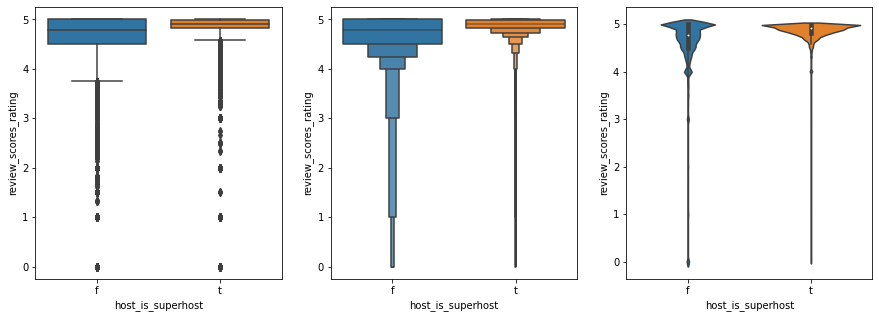

In [13]:
#plot review scores per whether superhost-listing
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
sns.boxplot(x="host_is_superhost", y="review_scores_rating", data=temp_calendar_df, ax=axs[0])
sns.boxenplot(x="host_is_superhost", y="review_scores_rating", data=temp_calendar_df, ax=axs[1])
sns.violinplot(x="host_is_superhost", y="review_scores_rating", data=temp_calendar_df, ax=axs[2])

<AxesSubplot:xlabel='host_is_superhost', ylabel='listing_id_count'>

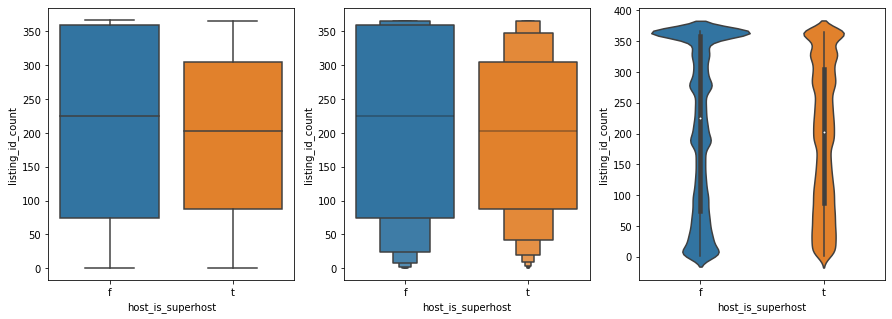

In [14]:
#plot booking count per whether superhost-listing
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
sns.boxplot(x="host_is_superhost", y="listing_id_count", data=temp_calendar_df, ax=axs[0])
sns.boxenplot(x="host_is_superhost", y="listing_id_count", data=temp_calendar_df, ax=axs[1])
sns.violinplot(x="host_is_superhost", y="listing_id_count", data=temp_calendar_df, ax=axs[2])

<AxesSubplot:xlabel='host_is_superhost', ylabel='price_median'>

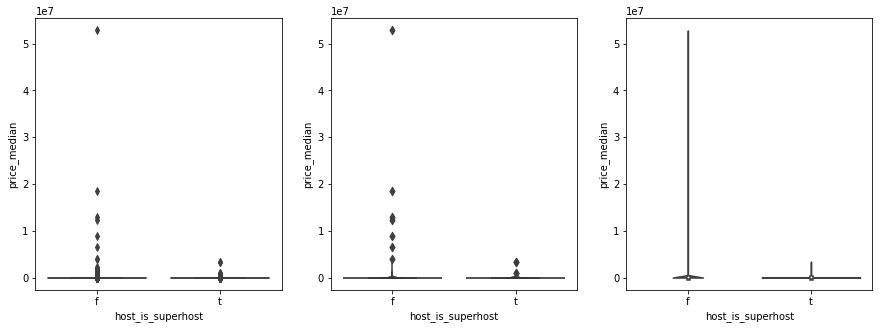

In [15]:
#plot price median per whether superhost-listing
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
sns.boxplot(x="host_is_superhost", y="price_median", data=temp_calendar_df, ax=axs[0])
sns.boxenplot(x="host_is_superhost", y="price_median", data=temp_calendar_df, ax=axs[1])
sns.violinplot(x="host_is_superhost", y="price_median", data=temp_calendar_df, ax=axs[2])

<AxesSubplot:xlabel='host_is_superhost', ylabel='price_median'>

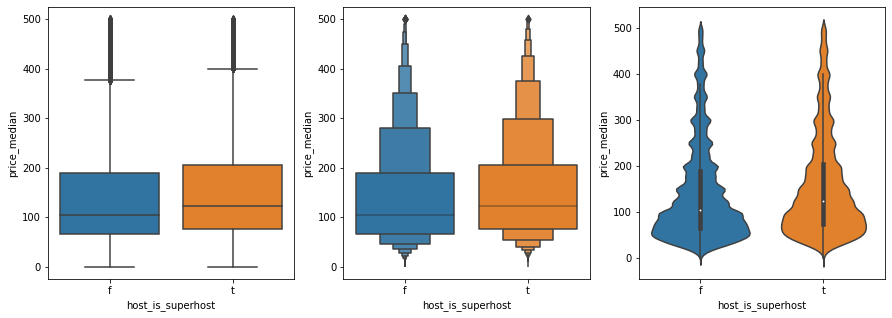

In [16]:
#plot truncated price median per whether superhost-listing
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
sns.boxplot(x="host_is_superhost", y="price_median", data=temp_calendar_df[temp_calendar_df['price_median'] < 500], ax=axs[0])
sns.boxenplot(x="host_is_superhost", y="price_median", data=temp_calendar_df[temp_calendar_df['price_median'] < 500], ax=axs[1])
sns.violinplot(x="host_is_superhost", y="price_median", data=temp_calendar_df[temp_calendar_df['price_median'] < 500], ax=axs[2])